# Importing Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix, f1_score, roc_curve,auc
from sklearn.decomposition import PCA

# Importing Dataset

In [ ]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [ ]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# Encoding Categorical Values

In [ ]:
categorical_column = ['Attrition', 'BusinessTravel', 'Department','Gender', 'JobRole', 'MaritalStatus', 'OverTime','EducationField']
encoder=LabelEncoder()
df[categorical_column]=df[categorical_column].apply(encoder.fit_transform)

# Seperating into X and y

In [ ]:
y=df['Attrition']
X=df.drop(['EmployeeCount','Attrition','EmployeeNumber','Over18','StandardHours'],axis=1)


# Spliting into Train and Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

## PCA

[0.15585089 0.06516771 0.05941482 0.05609608 0.05490863 0.041124
 0.03922775 0.03753547 0.03649764 0.03590089 0.03489955 0.03376771
 0.03271837 0.03199232 0.03110036 0.03075427 0.02949616 0.02931725
 0.02804284 0.02738458 0.02383979]
Two PCs explain 91.50370689722943 % of variance cumulatively


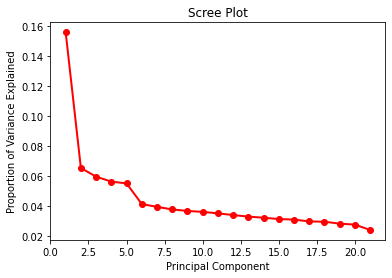

In [ ]:
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=21, random_state=0)
principalComponents = pca.fit_transform(StandardScaler().fit_transform(X_train))
print(pca.explained_variance_ratio_)
print('Two PCs explain', sum(pca.explained_variance_ratio_)*100, '% of variance cumulatively')
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter(principalComponents, x=0, y=1, color=y_train)
fig.show()
X_train = principalComponents
X_test = pca.transform(X_test)

# Hyperparameter tuning using GridSearchCV

In [ ]:
def tune_hyperparameters(model,X,y):
  param_grid = {
      'n_estimators' : [10,50,250,1000],
      'learning_rate' : [0.001,0.01,0.1,1.0,10]
  }
  grid_search = GridSearchCV(model,param_grid=param_grid)
  grid_search.fit(X,y)
  print("Best Params: ",grid_search.best_params_)
  return grid_search.best_params_

In [ ]:
decision_tree_parameters = {'criterion': 'entropy', 'max_depth': 6, 'max_features': 0.33334, 'max_leaf_nodes': 50, 'min_samples_leaf': 15, 'min_samples_split': 2, 'random_state': 0}

In [ ]:
best_parameters_raw = tune_hyperparameters(AdaBoostClassifier(random_state=0,base_estimator=DecisionTreeClassifier(**decision_tree_parameters)),X_train,y_train)

Best Params:  {'learning_rate': 0.01, 'n_estimators': 1000}


# AdaBoostClassifier

In [ ]:
def train_predict_evaluate(model,X_train,y_train,X_test):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  print("Accuracy: ",accuracy_score(y_test,y_pred))
  print("Precision: ",precision_score(y_test,y_pred))
  print("Recall: ",recall_score(y_test,y_pred))
  print("F1 Score: ",f1_score(y_test,y_pred))
  print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

  
  fpr,tpr,thresholds = roc_curve(y_test,y_pred)
  plt.plot(fpr, tpr,color='green',label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
  plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.show()

Accuracy:  0.8253968253968254
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
Confusion Matrix:
 [[364   0]
 [ 77   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



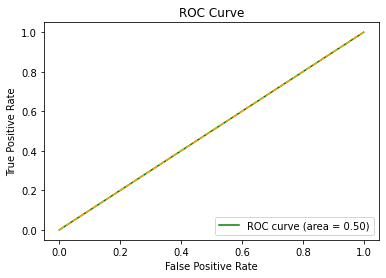

In [ ]:
train_predict_evaluate(AdaBoostClassifier(random_state=0,base_estimator=DecisionTreeClassifier(**decision_tree_parameters),**best_parameters_raw),X_train,y_train,X_test)

# K-Fold Cross Validation

In [ ]:
def cross_validation(model,X,y):
  scores = cross_validate(model, X, y, cv=5,scoring=('accuracy','precision','recall','f1'))

  metrics = []
  metrics.append(np.mean(scores['test_accuracy']))
  metrics.append(np.mean(scores['test_precision']))
  metrics.append(np.mean(scores['test_recall']))
  metrics.append(np.mean(scores['test_f1']))

  print("Accuracy: ",metrics[0])
  print("Precision: ",metrics[1])
  print("Recall: ",metrics[2])
  print("F1 Score: ",metrics[3])

In [ ]:
cross_validation(AdaBoostClassifier(random_state=0,base_estimator=DecisionTreeClassifier(**decision_tree_parameters),**best_parameters_raw),X,y)

Accuracy:  0.8585034013605443
Precision:  0.7694805194805194
Recall:  0.18147163120567375
F1 Score:  0.2926009392607042
